In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim import Adam

/var/folders/m2/pmjxjx5x06gfn7cms40klj3h0000gn/T/ipykernel_6326/255128325.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# importing data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
data = pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp')
data.index = pd.to_datetime(data.index)
train_size = int(data.shape[0]*0.8)

train, val, test = pd.DataFrame(data['value'][:int(train_size*3/4)]), pd.DataFrame(data['value'][int(train_size*3/4):train_size]), pd.DataFrame(data['value'][train_size:])
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
val_scaled  = scaler.transform(val)
test_scaled = scaler.transform(test)


In [3]:
test.max()

value    30236
dtype: int64

In [4]:
class TaxiDataset(Dataset):
    def __init__(self, data, lookback_window, forward_window, device):
        self.data = data
        self.lookback_window = lookback_window
        self.forward_window = forward_window
        self.device = device
        
    def __len__(self):
        return self.data.shape[0]-self.lookback_window-self.forward_window

    def __getitem__(self,idx):
        item = self.data[idx:idx+self.lookback_window]
        label = self.data[idx+self.lookback_window:idx+self.lookback_window+self.forward_window]
        
        return torch.tensor(item, dtype = torch.float32, device = self.device) ,torch.tensor(label, dtype = torch.float32, device = self.device)

In [8]:
forward_window  = 1
lookback_window  = 48
device = 'cuda' if torch.cuda.is_available() else 'cpu'


train_dataset = TaxiDataset(train_scaled, lookback_window, forward_window, device)
val_dataset = TaxiDataset(val_scaled,lookback_window,forward_window, device)
test_dataset = TaxiDataset(test_scaled, lookback_window, forward_window, device)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size= 32)
val_dataloader = DataLoader(val_dataset, batch_size= 32)
test_dataloader = DataLoader(test_dataset, batch_size= 32)

In [7]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, forward_window, lookback_window):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(lookback_window,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,forward_window)
        
    def forward(self,x, batch):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(batch,64)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x.unsqueeze(1)

In [164]:
model = CNN_ForecastNet(forward_window, lookback_window)
num_epochs = 100
lr = 0.001
optimiser = Adam(model.parameters(),lr=lr)
criterion = nn.MSELoss()

In [165]:
training_loss = []
val_loss = []

for epoch in range(num_epochs):
    training_running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        batch_size = inputs.shape[0]
        # Zero the parameter gradients
        optimiser.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs, batch_size)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        # Print statistics
        training_running_loss += loss.item()
    
            
    # Validation loop
    model.eval()  # Set model to evaluation mode
    validation_running_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            batch_size = inputs.shape[0]
            outputs = model(inputs, batch_size)
            loss = criterion(outputs, labels)
            validation_running_loss += loss

    epoch_train_loss = training_running_loss/len(train_dataloader)
    epoch_val_loss = validation_running_loss/len(val_dataloader)
    training_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    print(f'EPOCH {epoch}')
    print(f'Training Loss: {epoch_train_loss}')
    print(f'Validation Loss: {epoch_val_loss}')

EPOCH 0
Training Loss: 0.011415851535881908
Validation Loss: 0.004190082661807537
EPOCH 1
Training Loss: 0.002837338837707648
Validation Loss: 0.0024097382556647062
EPOCH 2
Training Loss: 0.0018211199746171285
Validation Loss: 0.002115538576617837
EPOCH 3
Training Loss: 0.0013694642146523013
Validation Loss: 0.001570620108395815
EPOCH 4
Training Loss: 0.00116415022360646
Validation Loss: 0.0013956839684396982
EPOCH 5
Training Loss: 0.001075870051484647
Validation Loss: 0.00147814373485744
EPOCH 6
Training Loss: 0.0010060006059120497
Validation Loss: 0.0012189344270154834
EPOCH 7
Training Loss: 0.0009823261865828197
Validation Loss: 0.0009553119307383895
EPOCH 8
Training Loss: 0.0009130049818395491
Validation Loss: 0.0008288562530651689
EPOCH 9
Training Loss: 0.0008672062608638953
Validation Loss: 0.0007622377597726882
EPOCH 10
Training Loss: 0.0008415429202462595
Validation Loss: 0.0007077164482325315
EPOCH 11
Training Loss: 0.000810074679899723
Validation Loss: 0.0006790577317588031
E

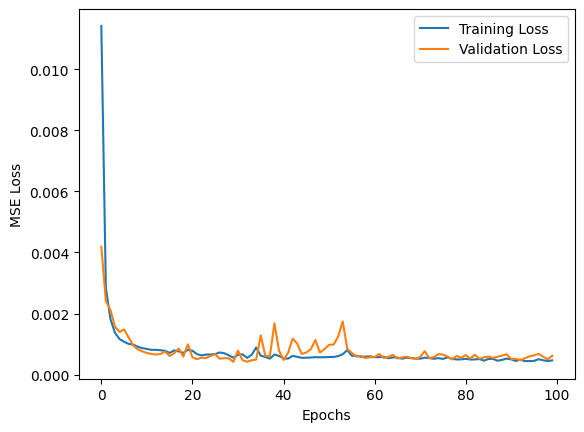

In [166]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

In [237]:
test_predictions = []
test_labels = []
model.eval()
with torch.no_grad():
    for data in test_dataloader:
        input, label = data
        test_labels.append(label.view(-1))
        test_predictions.append(np.array(model(input, input.shape[0]).view(-1)))
        
test_predictions = np.concatenate(test_predictions, axis = 0)
test_labels = np.concatenate(test_labels, axis = 0)

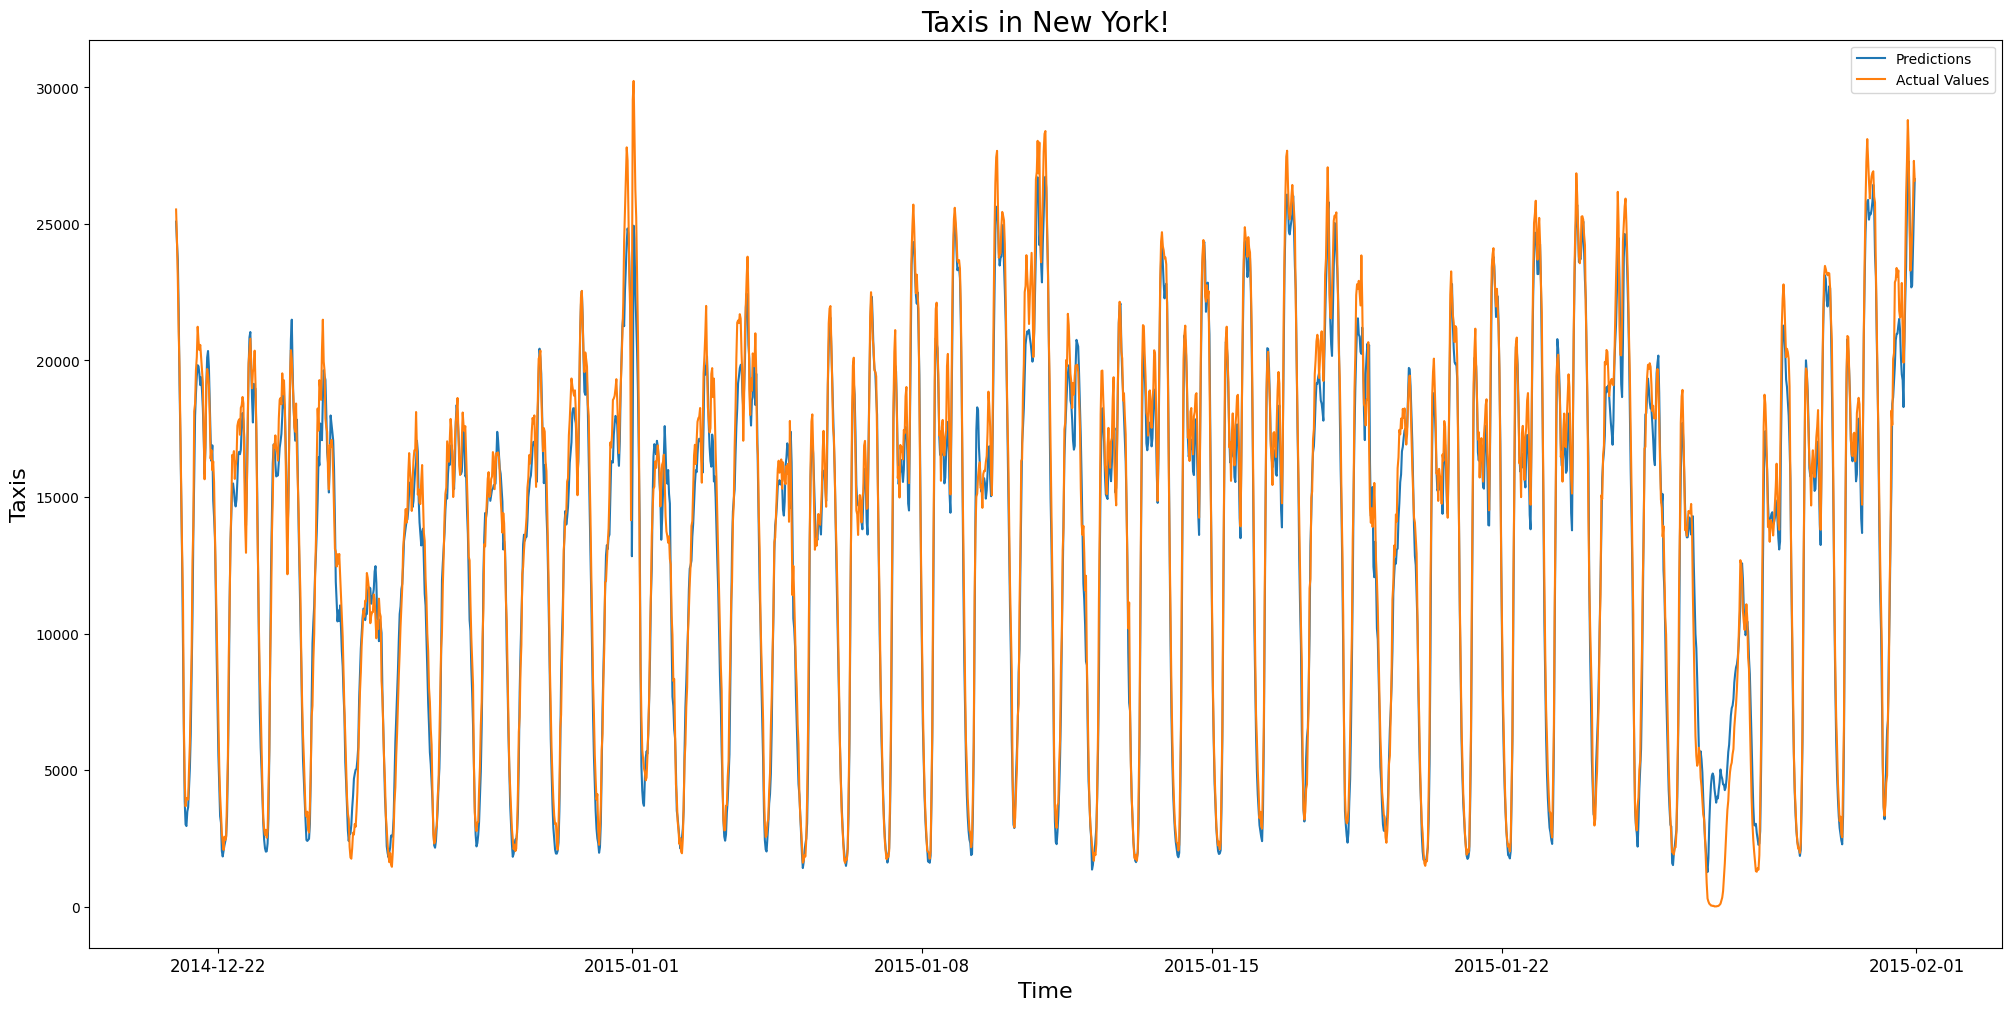

In [251]:
fig, axis = plt.subplots(constrained_layout = True, figsize = (20,10))

axis.plot(test.iloc[lookback_window:-forward_window].index.map(pd.to_datetime), scaler.inverse_transform(test_predictions.reshape(-1,1)), label = 'Predictions')
axis.plot(test.iloc[lookback_window:-forward_window].index.map(pd.to_datetime), scaler.inverse_transform(test_labels.reshape(-1,1)), label = 'Actual Values')
axis.set_xlabel('Time', fontsize = 16)
axis.set_ylabel('Taxis', fontsize = 16)
axis.tick_params(axis='x', labelsize=12) 
axis.set_title('Taxis in New York!', fontsize = 20)
axis.legend()